### FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.motifs import pYmotifs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [3]:
X = preprocessing(AXLwt=True, Vfilter=False, FCfilter=False, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

treatments = d.index


0/1493 peptides were not found in the proteome.
1493


In [4]:
d

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870
PC9,0.891610,-0.358784,0.136615,0.413272,2.028584,-0.789124,0.398969,-0.297124,0.172706,-0.117404,-0.009540,0.409301,-0.247217,0.137779,0.092089,...,0.704066,0.101719,-0.210772,0.315260,-0.288012,-0.199057,0.083787,1.332954,2.169358,-1.130117,1.316789,2.694753,0.577963,0.770174,1.305788
Erl,-0.132290,0.566052,-0.096407,0.620284,1.620221,-0.270084,-0.087536,-0.005490,0.015600,0.026626,-0.126487,0.263841,-0.354743,0.064661,0.525990,...,0.321475,0.001506,-1.350055,0.145629,-0.256027,0.454706,0.358233,0.218145,1.570918,0.502080,0.388504,0.852521,0.026361,0.664380,-0.140178
R428,0.508638,-0.052941,0.066187,0.352508,1.301309,-0.676451,-0.026767,0.116918,0.179464,-0.220300,0.060711,0.234600,-0.141233,0.095147,0.012584,...,0.075886,-0.144408,-0.560998,0.066405,-0.225507,0.653321,0.178745,0.715802,0.620437,-0.071912,0.263724,0.959014,0.046690,0.215155,0.560394
Erl/R428,-0.431225,-0.706288,-0.318742,-0.291815,-0.568873,-0.143864,-0.242677,-0.041076,-0.046343,-0.024090,0.249638,0.007094,0.133679,0.086857,0.583682,...,-0.266653,-0.086224,0.065785,-0.287281,-0.122223,0.118713,0.079776,-0.298889,-1.374179,-0.505972,-1.455803,-1.434426,0.203022,-0.371144,-0.341179
Erl+HGF,-0.008149,-0.172295,-0.249576,0.122734,-0.712916,0.154265,0.073363,-0.157658,-0.086309,-0.291813,-0.144648,-0.063472,0.097310,0.047585,0.215550,...,0.079803,0.238026,-0.264265,0.033551,0.109054,0.350850,0.036871,-0.191230,0.289226,-0.238505,0.597152,0.582779,0.399508,0.243069,-0.250761
Erl+FGF,0.338497,0.334636,0.048889,0.216532,-0.731959,-0.435783,0.102959,-0.186365,0.093422,-0.245455,-0.041766,0.049989,0.090287,0.095351,-0.128648,...,0.042296,0.059869,-0.583999,0.069366,0.135095,-0.040757,-0.145585,0.220133,-0.012489,-0.312330,0.022433,-0.266371,0.017095,-0.974646,-0.073179
Erl+IGF,-0.481326,0.246512,-0.209506,0.167650,-0.791261,-0.021593,-0.013749,-0.035143,0.046119,-0.155121,0.143250,-0.064102,0.314129,0.121568,-0.055638,...,-0.010690,0.603850,1.222372,0.023668,0.092834,-0.211529,-0.136258,-0.817064,0.232086,-1.067742,0.432893,-0.040972,-0.176009,-0.135812,-0.065153
KO Erl,-0.713501,0.255195,0.095823,-0.586405,-0.762381,0.246977,-0.281104,0.390447,-0.167274,0.066389,0.072214,-0.432393,0.024115,-0.077963,-0.739524,...,-0.360344,-0.504786,0.066240,-0.109561,0.208458,-0.172431,-0.215141,0.119038,-0.981527,0.000352,-0.449084,-1.194264,-0.181494,-0.420009,-0.676516
KO R428,0.547278,0.644213,0.241643,-0.395571,-0.574292,0.358189,0.020479,0.482194,-0.117651,0.469875,-0.011765,-0.172979,0.024195,-0.171258,-0.205843,...,0.002694,-0.096500,1.714528,-0.048382,0.195376,0.132210,-0.043670,-0.895555,-1.024902,1.041877,-0.012254,-0.760311,-0.215097,-0.759263,0.236585
KO Erl/R428,-0.519532,-0.756300,0.285073,-0.619189,-0.808433,1.577468,0.056064,-0.266704,-0.089734,0.491293,-0.191607,-0.231880,0.059478,-0.399726,-0.300242,...,-0.588533,-0.173054,-0.098834,-0.208655,0.150952,-1.086025,-0.196758,-0.403334,-1.488927,1.782267,-1.104353,-1.392723,-0.698038,0.768097,-0.555803


In [5]:
treatments

Index(['PC9', 'Erl', 'R428', 'Erl/R428', 'Erl+HGF', 'Erl+FGF', 'Erl+IGF',
       'KO Erl', 'KO R428', 'KO Erl/R428'],
      dtype='object')

In [6]:
X.shape

(871, 15)

### Phenotypes

#### Cell Viability:

In [7]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw4.csv').iloc[:29, :11]

itp = 0
ftp = 72


for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[itp, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[itp, ii]

y_ = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
y_ = y_.reset_index()[Y_cv1.columns]
y = pd.DataFrame()
y["Cell Viability"] = y_[y_["Elapsed"] == ftp].iloc[0, 1:]

In [8]:
from scipy.stats import zscore
y.iloc[:, :] = zscore(y.iloc[:, :])
y

,Cell Viability
PC9,2.208011
E,-0.362599
R,-0.262451
ER,-0.981351
EHGF,0.506524
EFGF,1.306331
EIGF,-0.113511
KOE,-0.790817
KOR,-0.423649
KOER,-1.086487


# 1-.Fitting PLSR model to the full data set

#### R2Y/Q2Y

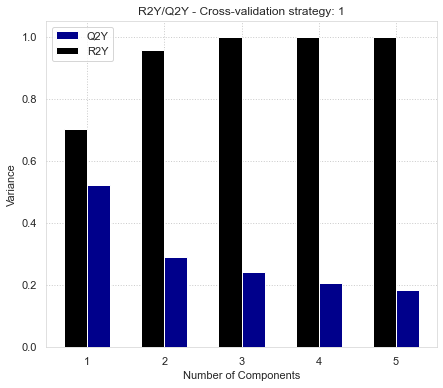

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p1 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p1, d, y, 1, 6)

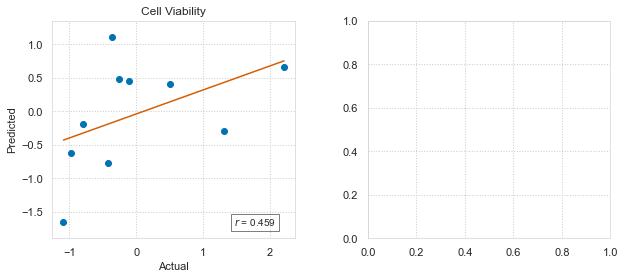

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p1, d, y, cv=1, y_pred="cross-validation")

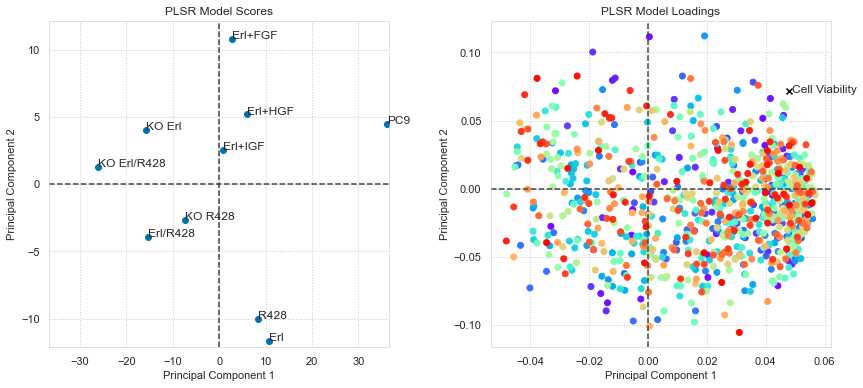

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p1.fit(d, y), d, y, 0, treatments, cv=1, data="full", annotate=False)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

# 2-Clustering and PLSR model

In [12]:
ncl = 10

## 2.1-Standard Clustering methods + PLSR

#### k-means:

In [13]:
from sklearn.cluster import KMeans

labels = KMeans(n_clusters=ncl).fit(d.T).labels_
x_ = X.copy()
x_["Cluster"] = labels
c1 = x_.groupby("Cluster").mean().T

#### SKLEARN's GMM:

In [14]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=ncl).fit(d.T)
# x_ = X.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### POMEGRANATE's GMM:

In [15]:
# from pomegranate import GeneralMixtureModel, NormalDistribution

# gmm = GeneralMixtureModel.from_samples(NormalDistribution, X=d.T, n_components=ncl, n_jobs=-1)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### R2Y/Q2Y

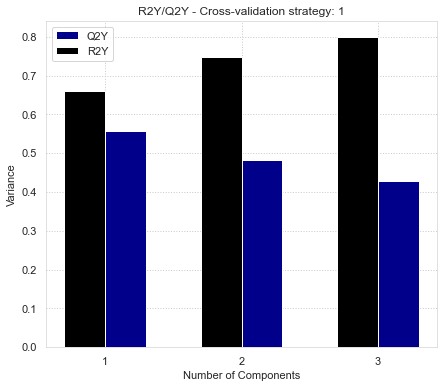

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p2 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p2, c1, y, 1, 4)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

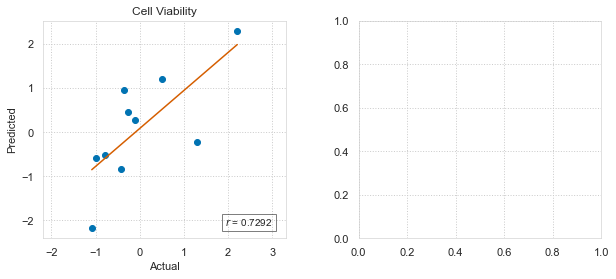

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p2, c1, y, cv=1, y_pred="cross-validation")

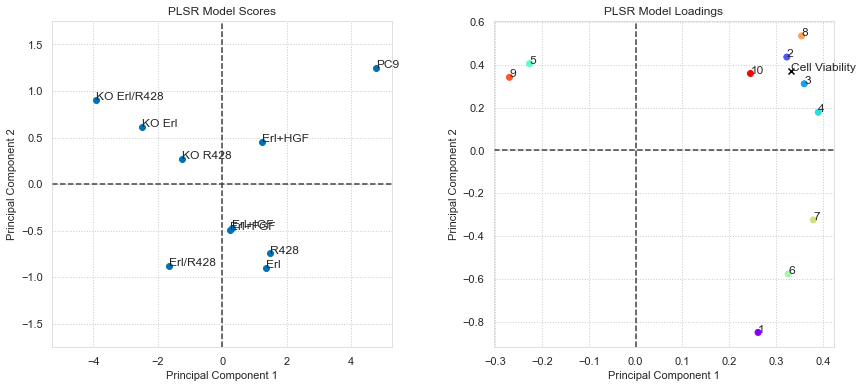

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p2.fit(c1, y), c1, y, ncl, treatments, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.2-Co-clustering and PLSR

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

In [ ]:
PAM250: 10 clusters and a weight of 1000000

### Fitting PLSR each time

In [66]:
distance_method = "PAM250"
ncl = 10
SeqWeight = 15000

MSC = MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(d, y)
c2 = MSC.transform(d)

#### R2Y/Q2Y

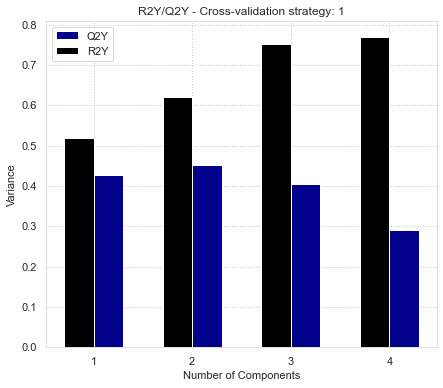

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p3 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p3, c2, y, 1, 5)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

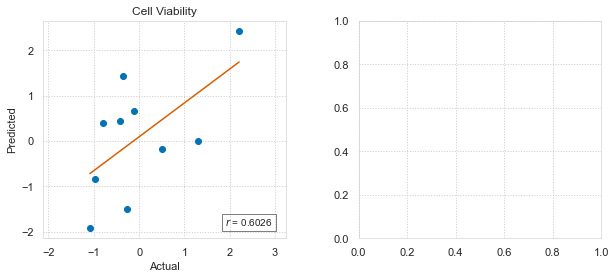

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p3, c2, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
raise SystemExit

#### Scores & Loadings

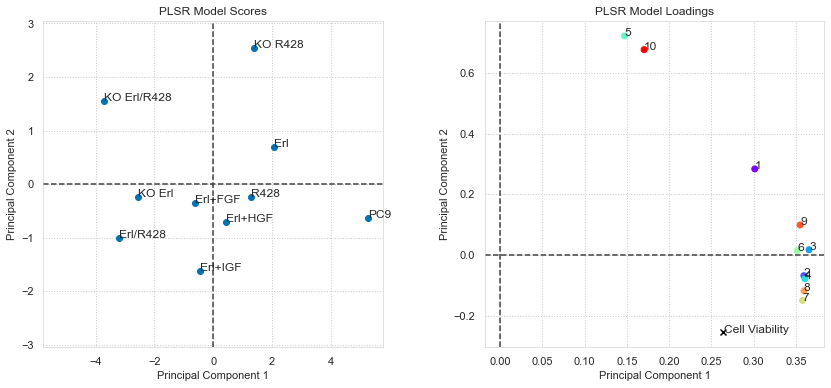

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, treatments, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.3-Random clustering and PLSR

In [77]:
from random import choices
x__ = X.copy()
x__["Cluster"] = choices(list(np.arange(ncl)), k=X.shape[0])
c3 = x__.groupby("Cluster").mean().T

#### R2Y/Q2Y

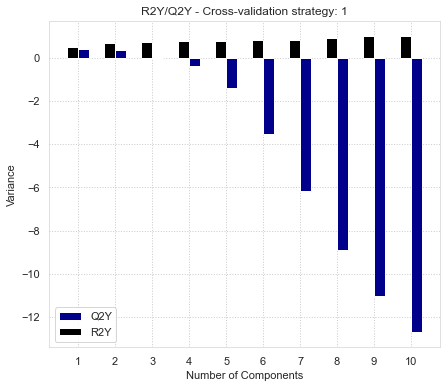

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p4 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p4, c3, y, 1, ncl+1)

#### Predictions

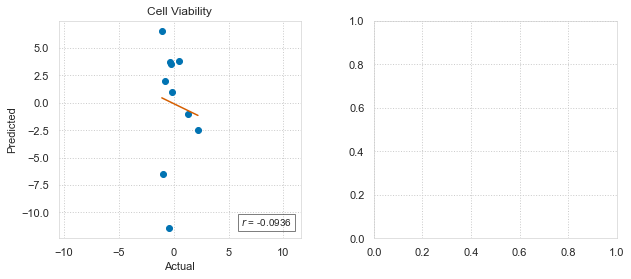

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p4, c3, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [81]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = CoCl_plsr.fit(d, y)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

#### R2Y/Q2Y

Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 2
Re-initialize GMM clusters, empty cluster(s) at iteration 3
Re-initialize GMM clusters, empty cluster(s) at iteration 4
Re-initialize GMM clusters, empty cluster(s) at iteration 5
Re-initialize GMM clusters, empty cluster(s) at iteration 6
Re-initialize GMM clusters, empty cluster(s) at iteration 7
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 2
Re-initialize GMM clusters, empty cluster(s) at iteration 3
Re-initialize GMM clusters, empty cluster(s) at iteration 4
Re-initialize GMM clusters, empty cluster(s) at iteration 5
Re-initialize GMM clusters, empty cluster(s) at iteration 6
Re-initialize GMM clusters, empty cluster(s) at iteration 7
Re-initialize GMM clusters, empty cluste

KeyboardInterrupt: 

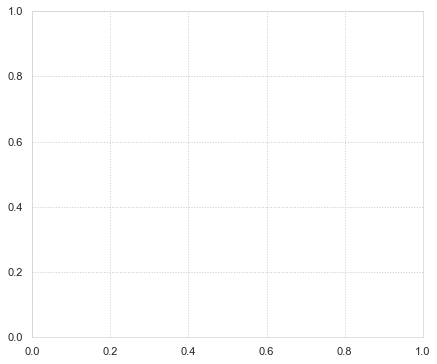

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=5)

#### GridSearch

Run:

In [ ]:
scores = MSclusPLSR_tuning(d, i, y, "PAM250")
scores = pd.DataFrame(scores)
hp = scores.sort_values(by="mean_test_scores", ascending=False)
hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))

In [ ]:
hp2 = scores[scores["#Components"]==2].sort_values(by="mean_test_scores", ascending=False)
hp2.insert(0, "Ranking", list(np.arange(1, hp2.shape[0]+1)))

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
plotActualVsPredicted(ax, CoCl_plsr, d, y, 2)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, lines, 2)

In [ ]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")